## Figure 7

Analysis of feature correlation in topological featurization and use of featurization by extracting the largest subtribes in volumetric samples

In [1]:
from toposample import Config, TopoData
from toposample.data import read_h5_dataset, read_multiple_h5_datasets
from figure_helper import FigureHelper
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from helper_functions import samples_overlap
from plot_helpers import adjust_color_brightness
import json
import h5py
import numpy

"""
Paths to relevant data.
"""
cfg = Config("../working_dir/config/common_config.json")
fn_tribes = cfg._cfg['analyzed']['tribes']
fn_features = cfg._cfg['analyzed']['features']
fn_features_acc = cfg._cfg['analyzed']['classifier_features_results']

"""
Additional parameterization, like which examples to plot and in which color
"""

# Manual selection of parametric sampling specifiers
specs_param = ['Transitive clustering coefficient', 'Adjacency spectral gap (low)', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic']

# Panel-A
panel_a_show_points = True
panel_a_show_errbars = True

# Panel-B
param_spec_sel = ['Adjacency spectral gap (low)', 'Efferent extension rate'] # Two examples of specifiers (parameter sampling) with low/high correlation

# Panel-C
panel_c_show_errbars = True

# Panel-E
panel_e_show_points = True
panel_e_show_errbars = True

# Panel-F
panel_f_show_points = True
panel_f_show_errbars = True

# Panel-G
panel_g_show_errbars = True

# Colors
col_param = 'tab:green' # Color for parameter sampling
col_vol = 'tab:blue' # Color for volumetric sampling
col_subtr = 'tab:red' # Color for subtribes in volumetric samples

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 7")

In [2]:
"""
Loading the data
"""
# Load tribes
tribe_gids = TopoData(fn_tribes)['gids']

# Load features (Euler characteristic values)
num_stimuli = 8
read_features = read_multiple_h5_datasets({f"stim{idx}": f"per_stimulus/stim{idx}" for idx in range(num_stimuli)})
ec_ftr = TopoData(fn_features, follow_link_functions={"data_fn": (read_features, True)})["data_fn"]
ec_ftr = ec_ftr.filter(index='0') # Assume that features are pooled to a single element at index '0'

# Merge feature trials of all stimuli
f_cat2 = lambda x: numpy.concatenate([x[k] for k in x.keys()], 2) # Concatenate along dim 2 (=trials)
ec_ftr = ec_ftr.map(f_cat2)

# Accuracies
read_scores = read_h5_dataset("scores")
ftr_acc = TopoData(fn_features_acc, follow_link_functions={"data_fn": (read_scores, True)})["data_fn"]
ftr_acc = ftr_acc.filter(index='0') # Assume that results are pooled to a single element at index '0'


In [3]:
"""
Some analysis of the data
"""
# Samples overlap
f_triu = lambda x: x[numpy.triu_indices(x.shape[0], 1, x.shape[1])] # Extract upper triangle matrix values
ovlp = tribe_gids.pool(['index'], func=samples_overlap).map(f_triu) # List of single pairwise overlap values

# Feature (Euler characteristic) correlation
f_cc = lambda x: numpy.nanmean([numpy.corrcoef(x[:, :, trial].T) for trial in range(x.shape[2])], 0) # Pairwise correlation within single trials, then mean over trials
ec_cc = ec_ftr.map(f_cc) # Pairwise correlation matrix
ec_cc_val = ec_cc.map(f_triu) # List of single pairwise correlation values

/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/gpfs/bbp.cscs.ch/home/pokorny/ToposampleKernel/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


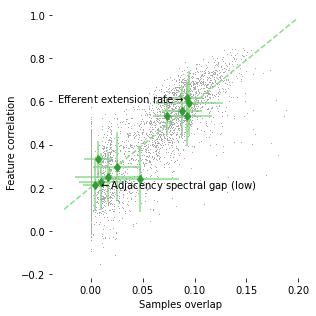

In [4]:
"""
Panel A: Average sample overlap vs feature correlation in champion samples
"""
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
all_x = []
all_y = []
for x, spec in enumerate(specs_param):
    data_ovlp = ovlp.get2(sampling='Parameter', specifier=spec)
    data_cc = ec_cc_val.get2(sampling='Parameter', specifier=spec)
    if panel_a_show_points:
        ax.plot(data_ovlp, data_cc, marker=',', ls='None', color='darkgrey')
    mean_ovlp = numpy.mean(data_ovlp)
    mean_cc = numpy.mean(data_cc)
    std_ovlp = numpy.std(data_ovlp)
    std_cc = numpy.std(data_cc)
    if panel_a_show_errbars:
        ax.errorbar(mean_ovlp, mean_cc, xerr=std_ovlp, yerr=std_cc, marker='d', ls='None', color=col_param, ecolor=adjust_color_brightness(colors.to_rgb(col_param), 1.75))
    else:
        ax.plot(mean_ovlp, mean_cc, marker='o', ls='None', color=col_param)
    all_x.append(mean_ovlp)
    all_y.append(mean_cc)

data_fit = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel('Samples overlap')
ax.set_ylabel('Feature correlation')
# ax.axis('tight')
x_range = numpy.array(ax.get_xlim())
ax.plot(x_range, data_fit[1] + data_fit[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_param), 1.75) if panel_a_show_points else 'grey', ls='--')
plt.box(False)

# Annotations
for x, spec in enumerate(param_spec_sel):
    mean_ovlp = numpy.mean(ovlp.get2(sampling='Parameter', specifier=spec))
    mean_cc = numpy.mean(ec_cc_val.get2(sampling='Parameter', specifier=spec))
    if mean_ovlp < numpy.mean(x_range):
        ax.text(mean_ovlp, mean_cc, r' $\leftarrow$' + spec, ha='left', va='center', color='k')
    else:
        ax.text(mean_ovlp, mean_cc, spec + r'$\rightarrow$ ', ha='right', va='center', color='k')

plt.tight_layout()
F.save(fig, "Panel-A")

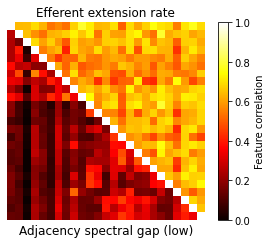

In [5]:
"""
Panel B: Two examples of sets of tribes with uncorrelated and highly correlated features
"""
# Pairwise feature correlation matrices (2 examples combined)
assert len(param_spec_sel) == 2, 'ERROR: Two specifiers required!'
fig = plt.figure(figsize=(4, 3.5))
cc_mat1 = ec_cc.get2(sampling='Parameter', specifier=param_spec_sel[0])
cc_mat2 = ec_cc.get2(sampling='Parameter', specifier=param_spec_sel[1])
cc_mat_comb = numpy.tril(cc_mat1, 0) + numpy.triu(cc_mat2, 1)
plt.imshow(cc_mat_comb, clim=(0, 1), cmap=cm.hot)
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.xlabel(param_spec_sel[0], fontsize=12)
plt.title(param_spec_sel[1], fontsize=12)
plt.tight_layout()
plt.colorbar(label='Feature correlation')
F.save(fig, "Panel-B")

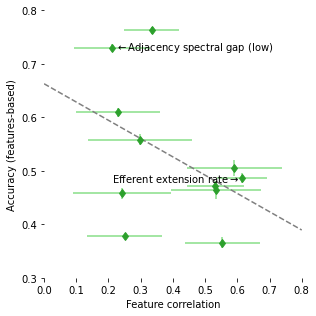

In [6]:
"""
Panel C: High average correlation leads to poor classification
"""
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
all_x = []
all_y = []
for x, spec in enumerate(specs_param):
    mean_cc = numpy.mean(ec_cc_val.get2(sampling='Parameter', specifier=spec))
    mean_acc = numpy.mean(ftr_acc.get2(sampling='Parameter', specifier=spec))
    std_cc = numpy.std(ec_cc_val.get2(sampling='Parameter', specifier=spec))
    std_acc = numpy.std(ftr_acc.get2(sampling='Parameter', specifier=spec))
    if panel_c_show_errbars:
        ax.errorbar(mean_cc, mean_acc, xerr=std_cc, yerr=std_acc, marker='d', ls='None', color=col_param, ecolor=adjust_color_brightness(colors.to_rgb(col_param), 1.75))
    else:
        ax.plot(mean_cc, mean_acc, marker='o', ls='None', color=col_param)
    all_x.append(mean_cc)
    all_y.append(mean_acc)

data_fit = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel('Feature correlation')
ax.set_ylabel('Accuracy (features-based)')
ax.axis('tight')
ax.set_xlim((numpy.floor(min(ax.get_xlim()) * 10) / 10, numpy.ceil(max(ax.get_xlim()) * 10) / 10))
ax.set_ylim((numpy.floor(min(ax.get_ylim()) * 10) / 10, numpy.ceil(max(ax.get_ylim()) * 10) / 10))
x_range = numpy.array(ax.get_xlim())
ax.plot(x_range, data_fit[1] + data_fit[0] * x_range, color='grey', ls='--')
plt.box(False)

# Annotations
for x, spec in enumerate(param_spec_sel):
    mean_cc = numpy.mean(ec_cc_val.get2(sampling='Parameter', specifier=spec))
    mean_acc = numpy.mean(ftr_acc.get2(sampling='Parameter', specifier=spec))
    if mean_cc < numpy.mean(x_range):
        ax.text(mean_cc, mean_acc, r' $\leftarrow$' + spec, ha='left', va='center', color='k')
    else:
        ax.text(mean_cc, mean_acc, spec + r'$\rightarrow$ ', ha='right', va='center', color='k')

plt.tight_layout()
F.save(fig, "Panel-C")

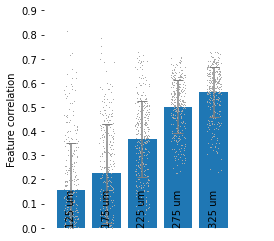

In [7]:
"""
Panel E1: Average feature correlation in volumetric samples
"""
specs_vol = ec_cc_val.filter(sampling='Radius').labels_of('specifier')

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
for x, spec in enumerate(specs_vol):
    data_cc = ec_cc_val.get2(sampling='Radius', specifier=spec)
    ax.bar(x, numpy.mean(data_cc), color=col_vol, width=0.8)
    if panel_e_show_points:
        ax.plot(x + 0.4 * (numpy.random.rand(len(data_cc)) - 0.5), data_cc, marker=',', ls='None', color='darkgrey')
    if panel_e_show_errbars:
        ax.errorbar(x, numpy.mean(data_cc), yerr=numpy.std(data_cc), color='grey', capsize=5)

ax.set_xticks(range(len(specs_vol)))
ax.set_xticklabels(specs_vol, rotation='vertical', va='bottom')
ax.tick_params(axis='x', length=0, pad=-1)
ax.set_ylabel('Feature correlation')
ax.set_xlim((-0.75, len(specs_vol) + 0.5))
ax.set_ylim((0, numpy.ceil(max(ax.get_ylim()) * 10) / 10))
ax.set_axisbelow(False)
plt.box(False)
F.save(fig, "Panel-E1")

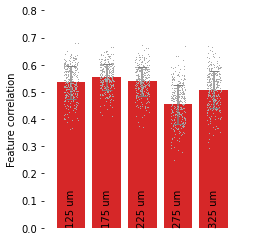

In [8]:
"""
Panel E2: Average feature correlation in subtribes samples
"""
specs_subtr = [spec + '@0' for spec in specs_vol] # Select first set of subtribes (..@0) consistent with specs_vol

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
for x, spec in enumerate(specs_subtr):
    data_cc = ec_cc_val.get2(sampling='subtribes', specifier=spec)
    ax.bar(x, numpy.mean(data_cc), color=col_subtr, width=0.8)
    if panel_e_show_points:
        ax.plot(x + 0.4 * (numpy.random.rand(len(data_cc)) - 0.5), data_cc, marker=',', ls='None', color='darkgrey')
    if panel_e_show_errbars:
        ax.errorbar(x, numpy.mean(data_cc), yerr=numpy.std(data_cc), color='grey', capsize=5)

ax.set_xticks(range(len(specs_subtr)))
ax.set_xticklabels(specs_vol, rotation='vertical', va='bottom')
ax.tick_params(axis='x', length=0, pad=-1)
ax.set_ylabel('Feature correlation')
ax.set_xlim((-0.75, len(specs_subtr) + 0.5))
ax.set_ylim((0, numpy.ceil(max(ax.get_ylim()) * 10) / 10))
plt.box(False)
F.save(fig, "Panel-E2")

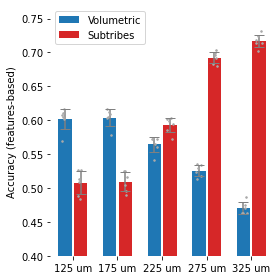

In [9]:
"""
Panel F: Overview of accuracies when using the largest 25 subtribes in volumetric samples
"""
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
for x, spec in enumerate(specs_vol):
    data_acc = ftr_acc.get2(sampling='Radius', specifier=spec)
    ax.bar(x - 0.175, numpy.mean(data_acc), color=col_vol, width=0.3, label='Volumetric' if x==0 else '')
    if panel_f_show_points:
        ax.plot(x - 0.175 + 0.15 * (numpy.random.rand(len(data_acc)) - 0.5), data_acc, marker='.', markersize=3, ls='None', color='darkgrey')
    if panel_f_show_errbars:
        ax.errorbar(x - 0.175, numpy.mean(data_acc), yerr=numpy.std(data_acc), color='grey', capsize=5)

for x, spec in enumerate(specs_subtr):
    data_acc = ftr_acc.get2(sampling='subtribes', specifier=spec)
    ax.bar(x + 0.175, numpy.mean(data_acc), color=col_subtr, width=0.3, label='Subtribes' if x==0 else '')
    if panel_f_show_points:
        ax.plot(x + 0.175 + 0.15 * (numpy.random.rand(len(data_acc)) - 0.5), data_acc, marker='.', markersize=3, ls='None', color='darkgrey')
    if panel_f_show_errbars:
        ax.errorbar(x + 0.175, numpy.mean(data_acc), yerr=numpy.std(data_acc), color='grey', capsize=5)

# ax.autoscale(tight=True)
ax.set_xticks(range(len(specs_vol)))
ax.set_xticklabels(specs_vol)
ax.set_ylabel('Accuracy (features-based)')
ax.set_xlim((-0.5, len(specs_vol) - 0.5))
ax.set_ylim((0.4, max(ax.get_ylim())))
plt.legend(loc='upper left')
plt.box(False)
plt.tight_layout()
F.save(fig, "Panel-F")

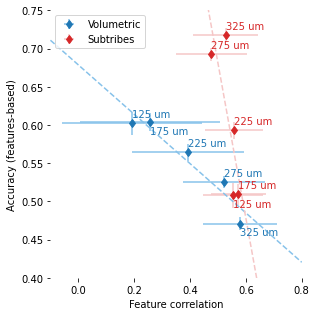

In [10]:
"""
Panel G: Feature correlation vs accuracy based on subtribes in volumetric samples
"""
fig = plt.figure(figsize=(4.5, 4.5))
ax = fig.gca()
all_x = []
all_y = []
spec_va = ['bottom', 'top', 'bottom', 'bottom', 'top']
for x, spec in enumerate(specs_vol):
    mean_cc = numpy.mean(ec_cc.get2(sampling='Radius', specifier=spec))
    mean_acc = numpy.mean(ftr_acc.get2(sampling='Radius', specifier=spec))    
    std_cc = numpy.std(ec_cc.get2(sampling='Radius', specifier=spec))
    std_acc = numpy.std(ftr_acc.get2(sampling='Radius', specifier=spec))    
    if panel_g_show_errbars:
        ax.errorbar(mean_cc, mean_acc, xerr=std_cc, yerr=std_acc, marker='d', ls='None', color=col_vol, ecolor=adjust_color_brightness(colors.to_rgb(col_vol), 1.75), label='Volumetric' if x==0 else '')
    else:
        ax.plot(mean_cc, mean_acc, marker='o', ls='None', color=col_vol, label='Volumetric' if x==0 else '')
    if spec_va[x] == 'bottom':
        y_offset = 0.005
    elif spec_va[x] == 'top':
        y_offset = -0.005
    else:
        y_offset = 0.0
    ax.text(mean_cc, mean_acc + y_offset, spec, ha='left', va=spec_va[x], color=col_vol)
    all_x.append(mean_cc)
    all_y.append(mean_acc)

data_fit_vol = numpy.polyfit(all_x, all_y, deg=1)

all_x = []
all_y = []
spec_va = ['top', 'bottom', 'bottom', 'bottom', 'bottom']
for x, spec in enumerate(specs_subtr):
    mean_cc = numpy.mean(ec_cc.get2(sampling='subtribes', specifier=spec))
    mean_acc = numpy.mean(ftr_acc.get2(sampling='subtribes', specifier=spec))
    std_cc = numpy.std(ec_cc.get2(sampling='subtribes', specifier=spec))
    std_acc = numpy.std(ftr_acc.get2(sampling='subtribes', specifier=spec))    
    if panel_g_show_errbars:
        ax.errorbar(mean_cc, mean_acc, xerr=std_cc, yerr=std_acc, marker='d', ls='None', color=col_subtr, ecolor=adjust_color_brightness(colors.to_rgb(col_subtr), 1.75), label='Subtribes' if x==0 else '')
    else:
        ax.plot(mean_cc, mean_acc, marker='o', ls='None', color=col_subtr, label='Subtribes' if x==0 else '')
    if spec_va[x] == 'bottom':
        y_offset = 0.005
    elif spec_va[x] == 'top':
        y_offset = -0.005
    else:
        y_offset = 0.0
    ax.text(mean_cc, mean_acc + y_offset, specs_vol[x], ha='left', va=spec_va[x], color=col_subtr)
    all_x.append(mean_cc)
    all_y.append(mean_acc)

data_fit_subtr = numpy.polyfit(all_x, all_y, deg=1)

ax.set_xlabel('Feature correlation')
ax.set_ylabel('Accuracy (features-based)')
ax.axis('tight')
ax.set_xlim((numpy.floor(min(ax.get_xlim()) * 10) / 10, numpy.ceil(max(ax.get_xlim()) * 10) / 10))
ax.set_ylim((numpy.floor(min(ax.get_ylim()) * 20) / 20, numpy.ceil(max(ax.get_ylim()) * 20) / 20))
x_range = numpy.array(ax.get_xlim())
ax.plot(x_range, data_fit_vol[1] + data_fit_vol[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_vol), 1.75), ls='--')
ax.plot(x_range, data_fit_subtr[1] + data_fit_subtr[0] * x_range, color=adjust_color_brightness(colors.to_rgb(col_subtr), 1.75), ls='--')
plt.box(False)
plt.legend(loc='upper left')
plt.tight_layout()
F.save(fig, "Panel-G")